# Analysing 10x Visium data with NMF and scllm

## Summary

In this code, we analyze spatial transcriptomics data from a mouse brain sample. We start by loading the necessary libraries and the dataset, then we perform quality control by filtering cells and genes based on specific criteria. We visualize the distribution of total counts and gene counts using histograms. Next, we normalize the data and identify highly variable genes. We apply Non-negative Matrix Factorization (NMF) to reduce the dimensionality of the data, extracting ten components. We then annotate these components using a language model to interpret their biological significance. Finally, we visualize the spatial distribution of the NMF components and their annotations, providing insights into the underlying cellular structures and functions in the brain tissue.

## Setup

1. **API Key Setup**: 
   We start by loading our OpenAI API key using the `dotenv` package. This allows us to securely access the ChatGPT model later in the script without hardcoding the key directly into our code.

2. **Importing Libraries**: 
   We import several essential libraries:
   - `scanpy` for handling single-cell data.
   - `scllm` for annotating our data using language models.
   - `squidpy` for working with spatial transcriptomics data.
   - `seaborn` and `matplotlib` for visualization.
   - `pandas` for data manipulation.
   - `NMF` from `sklearn` for performing non-negative matrix factorization.

In [ ]:
# Enter your API key for ChatGPT
# import os
# os.environ["OPENAI_API_KEY"] = "Enter your API key here."
# Or alternatively save your OPENAI key in a .env file and load it via dotenv
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI

import scanpy as sc
import scllm as sl
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import NMF

/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In these lines of code, we set up the language model that will help us with the annotation process. 

First, we define the variable `openai_model` and assign it the value `"gpt-4o-mini"`, which specifies the version of the OpenAI model we want to use. This model is designed to assist in generating annotations based on the data we provide.

Next, we create an instance of `ChatOpenAI` and assign it to the variable `llm`. We set the `temperature` parameter to `0.0`, which means we want the model to generate more deterministic and focused outputs, rather than creative or random ones. This is important for our task, as we want reliable annotations for our NMF results.


In [2]:
openai_model = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=openai_model)

In this part of the script, we are downloading the necessary data files for our analysis of the mouse brain using the 10x Genomics platform. 

1. **Downloading Data**: The `wget` commands fetch two files: the filtered feature barcode matrix (`V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5`) and the spatial data (`V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz`). These files contain the gene expression data and spatial coordinates, respectively.

2. **Organizing Files**: We then move these files into a `data` directory for better organization. This helps keep our workspace tidy.

3. **Extracting Spatial Data**: The `tar -xzf` command extracts the contents of the spatial data archive, which includes the spatial coordinates needed for visualization.

4. **Cleanup**: After extraction, we remove the original tar.gz file to save space, and finally, we move the extracted spatial data into a `spatial` directory.


In [3]:
# %%sh
# wget https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Mouse_Brain_Sagittal_Anterior/V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5 
# wget https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Mouse_Brain_Sagittal_Anterior/V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz 
# mv V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5 data
# mv V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz data
# tar -xzf data/V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz 
# rm data/V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz
# mv spatial data

In these lines of code, we are loading the 10x Genomics Visium dataset for the mouse brain. The function `sq.read.visium` reads the spatial transcriptomics data from the specified directory ("data") and the counts file ("V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5"). This gives us an AnnData object, `adata`, which is a convenient data structure for handling single-cell data.

Next, we call `adata.var_names_make_unique()`. This is important because it ensures that all variable (gene) names in our dataset are unique. In single-cell RNA-seq data, it's common to have duplicate gene names, and making them unique helps avoid confusion during analysis and visualization later on. 

In [4]:
adata = sq.read.visium("data", counts_file="V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()

/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata

AnnData object with n_obs × n_vars = 2695 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Data Proprocessing

In these lines of code, we first create a new column in the `adata.var` DataFrame called `"mt"`, which identifies mitochondrial genes. We do this by checking if the gene names (stored in `adata.var_names`) start with "mt-". This is important because mitochondrial gene expression can indicate cell health and quality.

Next, we use `sc.pp.calculate_qc_metrics` to compute quality control metrics for our data, specifically focusing on the mitochondrial genes we just flagged. By setting `qc_vars=["mt"]`, we calculate metrics like the percentage of counts coming from mitochondrial genes for each cell. This helps us assess the quality of our single-cell RNA-seq data, allowing us to filter out low-quality cells later on.

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In this part of the script, we are visualizing some quality control metrics.

First, we create a figure with four subplots using `plt.subplots(1, 4, figsize=(15, 4))`. This sets up a single row with four columns for our histograms.

Next, we plot the total counts of genes detected in each cell with `sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])`. This gives us a sense of the distribution of total counts across all cells.

In the second subplot, we focus on cells with total counts less than 10,000 using `sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])`. This helps us zoom in on lower-quality cells that might be outliers.

The third subplot visualizes the number of genes detected per cell with `sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])`, which is another important metric for assessing cell quality.

Finally, we again filter for lower-quality cells by plotting the number of genes detected, but this time we only include cells with fewer than 4,000 genes using `sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])`.

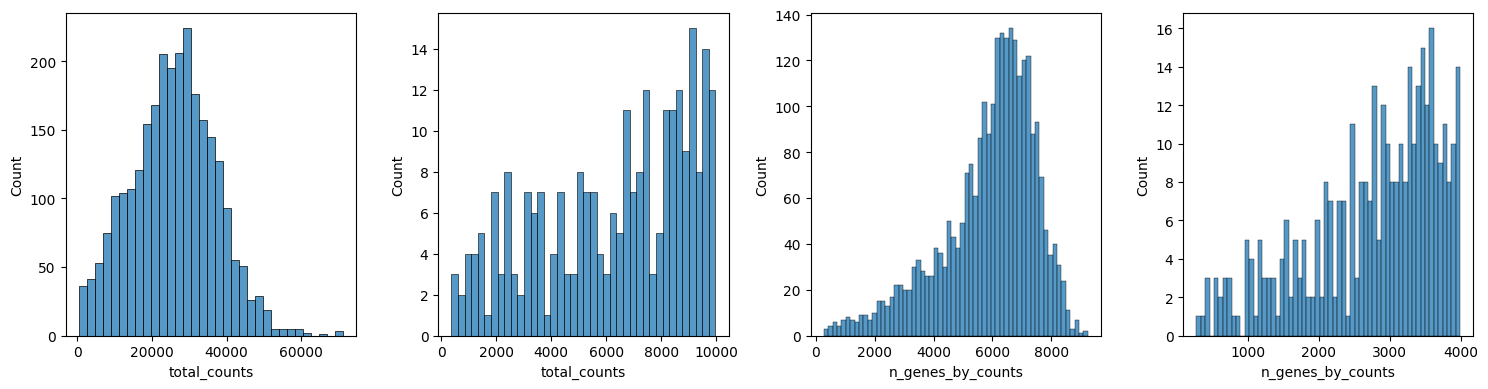

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
plt.tight_layout()

In this part of the script, we are cleaning up our data to ensure that we only keep high-quality cells and genes for our analysis. 

First, we use `sc.pp.filter_cells(adata, max_counts=50000)` to filter out any cells that have more than 50,000 total counts. This helps us remove potential outliers or low-quality cells that might skew our results.

Next, we filter out cells that have a high percentage of mitochondrial gene counts with `adata = adata[adata.obs.pct_counts_mt < 20]`. Here, we’re keeping only those cells where less than 20% of the total counts come from mitochondrial genes, which is a common practice to exclude dying or stressed cells.

Finally, we apply `sc.pp.filter_genes(adata, min_cells=10)` to remove genes that are not expressed in at least 10 cells. This step helps us focus on genes that are more likely to be biologically relevant and reduces noise in our dataset.

Overall, these lines are crucial for ensuring that our dataset is clean and suitable for downstream analyses like NMF and annotation.

In [9]:
sc.pp.filter_cells(adata, max_counts=50000)
adata = adata[adata.obs.pct_counts_mt < 20]
sc.pp.filter_genes(adata, min_cells=10)

/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In this part of the script, we are preparing our data for downstream analysis after loading the 10x Visium dataset. 

First, we use `sc.pp.normalize_total(adata, inplace=True)`. This line normalizes the total counts for each cell to account for differences in sequencing depth. Essentially, it ensures that we can compare gene expression levels across cells on a common scale.

Next, we apply `sc.pp.log1p(adata)`. This function takes the natural logarithm of the normalized counts plus one. The log transformation helps to stabilize the variance and makes the data more normally distributed, which is often a requirement for many statistical analyses.

Finally, we call `sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, subset=True)`. Here, we identify the top 2000 highly variable genes using the Seurat method. These genes are crucial for distinguishing different cell types or states, as they show the most variation across our dataset. By setting `subset=True`, we filter the dataset to keep only these highly variable genes for further analysis.

So, in summary, we normalize the data, log-transform it for better statistical properties, and then focus on the most informative genes for our analysis.

In [10]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, subset=True)

In this part of the script, we use the `sc.pl.spatial` function from the Scanpy library to visualize the spatial distribution of two metrics: `total_counts` and `n_genes_by_counts`. 

Here's what happens:

1. **Spatial Plotting**: We’re creating a spatial plot of our data, which shows how the total counts of gene expression and the number of genes detected vary across the tissue section we’re analyzing.

2. **Parameters**: The `img_key="hires"` parameter indicates that we want to use the high-resolution image of the tissue for our plot. The `color` parameter specifies the metrics we want to visualize, which are `total_counts` (the total number of counts for each cell) and `n_genes_by_counts` (the number of genes detected in each cell).

This visualization helps us quickly assess the quality of our data and identify any potential issues, like areas with low gene expression or high total counts, which can inform our subsequent analysis steps.

/var/folders/_4/qhxlw4x53134ffft2v5pt3nh0000gn/T/ipykernel_55465/3976244732.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])


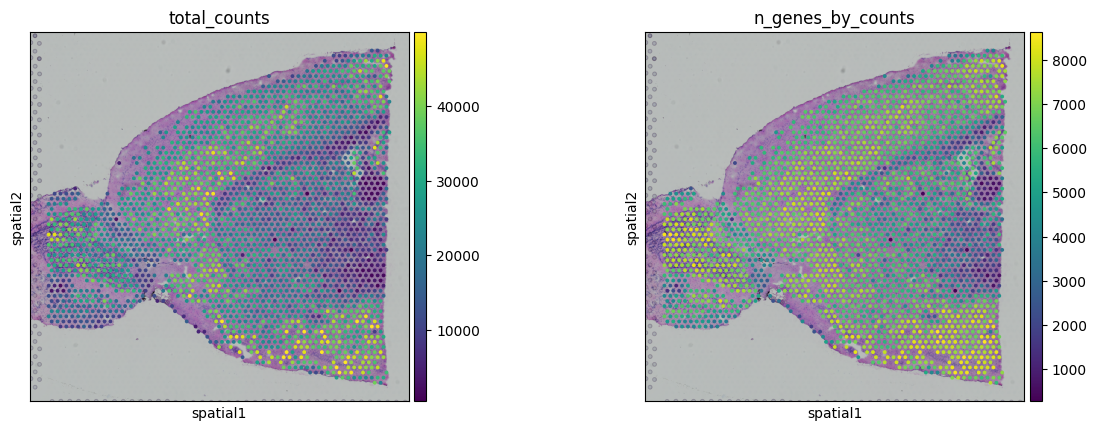

In [11]:
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

## Running NMF

In this part of the script, we’re setting up the Non-negative Matrix Factorization (NMF) algorithm. The line `nmf = NMF(n_components=10, max_iter=1000)` initializes the NMF model with two key parameters: 

1. **n_components=10**: This tells the model that we want to decompose our data into 10 distinct components or factors. Essentially, we’re looking to identify 10 different patterns or features in our gene expression data from the mouse brain.

2. **max_iter=1000**: This sets the maximum number of iterations for the optimization process. If the algorithm doesn’t converge to a solution within 1000 iterations, it will stop. This is important for ensuring that we give the model enough time to find a good representation of the data.

After this initialization, we use `Z = nmf.fit_transform(adata.X.toarray())` to actually perform the factorization on our data matrix, which is stored in `adata.X`. This will give us the transformed data in `Z`, which we can then use for further analysis and visualization.

In [12]:
nmf = NMF(n_components=10, max_iter=1000)

In this part of the script, we are applying Non-negative Matrix Factorization (NMF) to our single-cell RNA-seq data stored in the `adata` object. 

The line `Z = nmf.fit_transform(adata.X.toarray())` is where the magic happens. Here, we take the expression matrix `adata.X`, convert it to a dense array format (since NMF requires it), and then fit the NMF model to this data. The result, `Z`, is a matrix where each row corresponds to a cell and each column corresponds to a latent factor (or component) that captures the underlying structure of the data.

Next, `W = nmf.components_` retrieves the matrix of components learned by the NMF model. Each row in `W` represents a factor, and each column corresponds to a gene. This tells us how much each gene contributes to each factor.

In summary, we are decomposing our gene expression data into a set of components (factors) that can help us understand the underlying biological processes in the mouse brain dataset. This is a crucial step before we move on to annotating these factors with biological meaning using the `scllm` package.

In [13]:
Z = nmf.fit_transform(adata.X.toarray())
W = nmf.components_

In this part of the script, we are storing the results of our NMF (Non-negative Matrix Factorization) analysis into the AnnData object, which is a central data structure in the Scanpy ecosystem.

1. `adata.obsm['X_nmf'] = Z`: Here, we save the transformed data matrix `Z`, which contains the NMF components for each cell, into the `obsm` attribute of our AnnData object. This allows us to access the NMF representation of our data later on.

2. `adata.varm['NMF'] = W.T`: In this line, we store the NMF components (the basis matrix) `W`, transposed, into the `varm` attribute. This gives us the relationship between the original features (genes) and the NMF components, which can be useful for understanding which genes contribute to each component.

3. `adata.obs = pd.concat([...], axis=1)`: Finally, we concatenate the NMF components (from `Z`) as new columns in the `obs` DataFrame of our AnnData object. Each column corresponds to an NMF component (like `NMF0`, `NMF1`, etc.), making it easy to reference these components when we want to visualize or analyze them further.

Overall, these lines are crucial for integrating the results of our NMF analysis into the AnnData structure, setting us up for the subsequent annotation and visualization steps.

In [14]:
adata.obsm['X_nmf'] = Z
adata.varm['NMF'] = W.T
adata.obs = pd.concat([adata.obs, pd.DataFrame(Z, index=adata.obs.index, columns=[f'NMF{i}' for i in range(10)])], axis=1)

In this part of the script, we are simply displaying the `adata` object, which is an AnnData object containing our processed spatial transcriptomics data from the mouse brain. 

By calling `adata`, we can quickly check the current state of our data after all the preprocessing steps we've applied, like filtering cells and genes, normalizing the data, and performing NMF (Non-negative Matrix Factorization). This gives us a snapshot of the data structure, including the observations (cells) and variables (genes), along with any additional information we've added, such as the NMF components and their annotations. 

It's a handy way to ensure everything looks good before we move on to the annotation and visualization steps.

In [15]:
adata

AnnData object with n_obs × n_vars = 2448 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'NMF0', 'NMF1', 'NMF2', 'NMF3', 'NMF4', 'NMF5', 'NMF6', 'NMF7', 'NMF8', 'NMF9'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial', 'X_nmf'
    varm: 'NMF'

In this part of the script, we are visualizing the results of our NMF (Non-negative Matrix Factorization) analysis on the spatial transcriptomics data from the mouse brain. The line `sc.pl.spatial(adata, img_key="hires", color=["NMF0", "NMF1", "NMF2", "NMF3", "NMF4", "NMF5", "NMF6", "NMF7", "NMF8", "NMF9"])` generates spatial plots where we can see the expression patterns of the first ten NMF components (NMF0 to NMF9) across the tissue section.

By using the `img_key="hires"`, we ensure that the high-resolution image of the tissue is used as the background for our plots. The `color` parameter specifies which NMF components we want to visualize, allowing us to assess how these components are distributed spatially within the brain tissue. This helps us understand the underlying biological patterns captured by the NMF analysis.

/var/folders/_4/qhxlw4x53134ffft2v5pt3nh0000gn/T/ipykernel_55465/4223846374.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", color=["NMF0", "NMF1", "NMF2", "NMF3", "NMF4", "NMF5", "NMF6", "NMF7", "NMF8", "NMF9"])


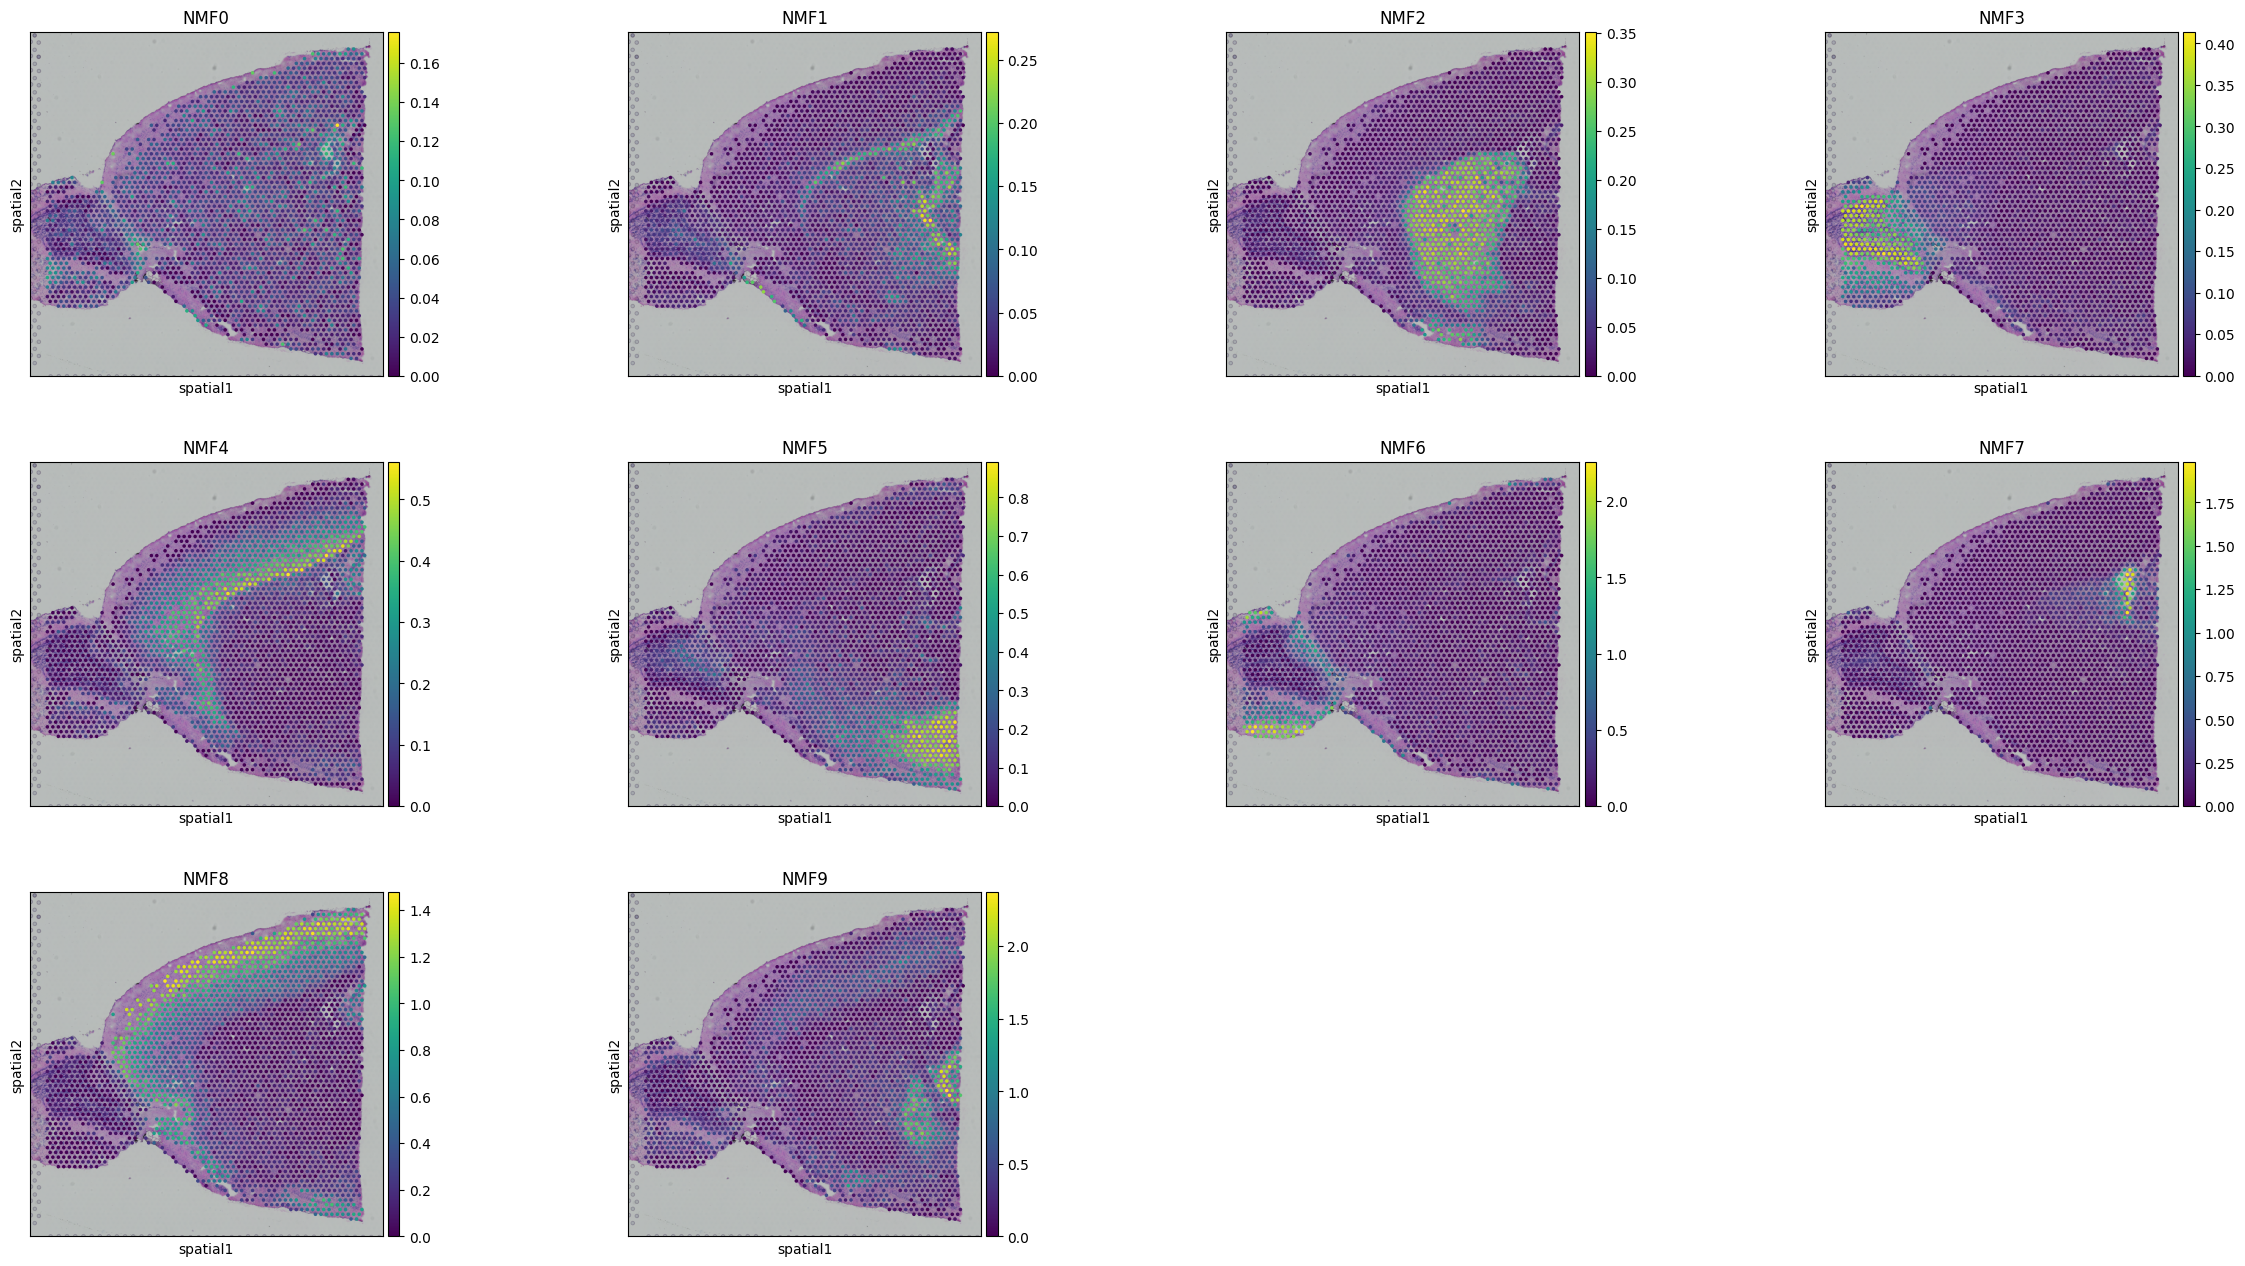

In [16]:
sc.pl.spatial(adata, img_key="hires", color=["NMF0", "NMF1", "NMF2", "NMF3", "NMF4", "NMF5", "NMF6", "NMF7", "NMF8", "NMF9"])

## Annotating NMF factors

In this part of the script, we’re using the `scllm` package to annotate the factors we obtained from our NMF (Non-negative Matrix Factorization) analysis. 

The `sl.tl.annotate_factor` function takes our `adata` object, which contains the results of our NMF, and uses a language model (in this case, `llm`) to generate meaningful annotations for the factors stored in `varm_key="NMF"`. The `sign="+"` parameter indicates that we want to focus on positive contributions to the factors, and `num_samples=10` specifies that we want to generate 10 samples for the annotations.

Essentially, this step helps us interpret the NMF components by providing biological context, making it easier to understand what each factor represents in terms of gene expression patterns. After running this, we can check the annotations in `adata.uns['factor_annotation']['mapping']` to see how the factors relate to biological functions or cell types.

In [29]:
sl.tl.annotate_factor(
    adata,
    varm_key="NMF",
    llm=llm,
    sign="+",
    num_samples=10
)

In this part of the script, we are accessing the `mapping` attribute from the `factor_annotation` dictionary stored in the `uns` (unstructured) slot of our AnnData object, `adata`. 

After we performed NMF (Non-negative Matrix Factorization) on our spatial transcriptomics data, we used the `scllm` package to annotate the factors we derived from the NMF. The line `sl.tl.annotate_factor(...)` generates annotations for each of the NMF components based on the learned patterns in the data. 

By calling `adata.uns['factor_annotation']['mapping']`, we can see the results of this annotation process. It gives us a mapping of the NMF factors to their corresponding biological interpretations or features, which helps us understand what each factor represents in the context of the mouse brain data. This is crucial for interpreting our results and making biological inferences from the NMF components.

In [30]:
adata.uns['factor_annotation']['mapping']

{'0+': 'Erythrocyte',
 '1+': 'Oligodendrocyte',
 '2+': 'Medium Spiny Neuron',
 '3+': 'Purkinje neuron',
 '4+': 'Excitatory Neuron',
 '5+': 'Neuroendocrine Cell',
 '6+': 'Astrocyte',
 '7+': 'Hepatocyte',
 '8+': 'Excitatory Neuron',
 '9+': 'Inhibitory Interneuron'}

In this part of the script, we are simply displaying the `adata` object, which is an AnnData object containing our processed spatial transcriptomics data from the mouse brain. 

By calling `adata`, we can quickly check the current state of our data after all the preprocessing steps we've applied, like filtering cells and genes, normalizing the data, and running NMF (Non-negative Matrix Factorization). This gives us a snapshot of the data structure, including the observations (cells) and variables (genes), along with any additional information we've added, such as the NMF components and their annotations. 

It's a handy way to ensure everything looks good before we move on to the annotation and visualization steps.

In [31]:
adata

AnnData object with n_obs × n_vars = 2448 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'NMF0', 'NMF1', 'NMF2', 'NMF3', 'NMF4', 'NMF5', 'NMF6', 'NMF7', 'NMF8', 'NMF9'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'factor_annotation'
    obsm: 'spatial', 'X_nmf'
    varm: 'NMF'

In this part of the script, we’re using the `factor_stripplot` function from the `scllm` package to visualize the results of our NMF (Non-negative Matrix Factorization) analysis. 

After we’ve performed NMF on our spatial transcriptomics data from the mouse brain, we have stored the NMF components in `adata.obsm['X_nmf']` and the factor annotations in `adata.uns['factor_annotation']['mapping']`. 

When we call `sl.pl.factor_stripplot`, we’re essentially creating a strip plot that shows how the different NMF factors (like NMF0, NMF1, etc.) are distributed across the cells in our dataset. The `obsm_key="X_nmf"` argument tells the function to use the NMF results for the x-axis, while `annotation_key="factor_annotation"` specifies that we want to color the points based on the factor annotations we generated earlier. 

This visualization helps us understand the spatial distribution of the different factors and how they relate to the underlying biological processes in the mouse brain tissue. It’s a great way to see the patterns and relationships in our data visually!

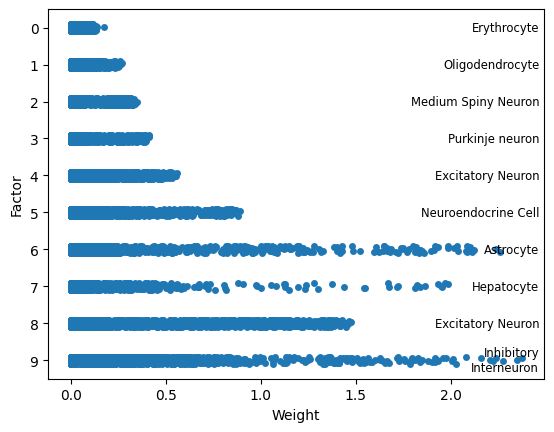

In [32]:
sl.pl.factor_stripplot(
    adata,
    obsm_key="X_nmf",
    annotation_key="factor_annotation",
)

In this part of the script, we are using the `factor_embedding` function from the `scllm` package to visualize the results of our NMF (Non-negative Matrix Factorization) analysis in a spatial context. 

Here's what happens:

1. **Function Call**: We call `sl.pl.factor_embedding`, passing in our `adata` object, which contains the processed data from the mouse brain dataset.
2. **Parameters**:
   - `obsm_key="X_nmf"`: This tells the function to use the NMF components we calculated earlier (stored in `adata.obsm['X_nmf']`) for the embedding.
   - `basis='spatial'`: We specify that we want to visualize the data in relation to its spatial coordinates, which is crucial for understanding how the different NMF factors are distributed across the tissue.
   - `annotation_key="factor_annotation"`: This indicates that we want to color the points in the plot based on the annotations we generated for the NMF factors.

3. **Visualization**: The function generates a plot that shows how the different NMF factors are spatially distributed in the mouse brain tissue, allowing us to see patterns and relationships in the data.

Finally, we call `plt.tight_layout()` to ensure that the layout of the plot is neat and doesn't overlap, making it easier to interpret. This visualization helps us understand the biological significance of the NMF factors in the context of the spatial organization of the brain tissue.

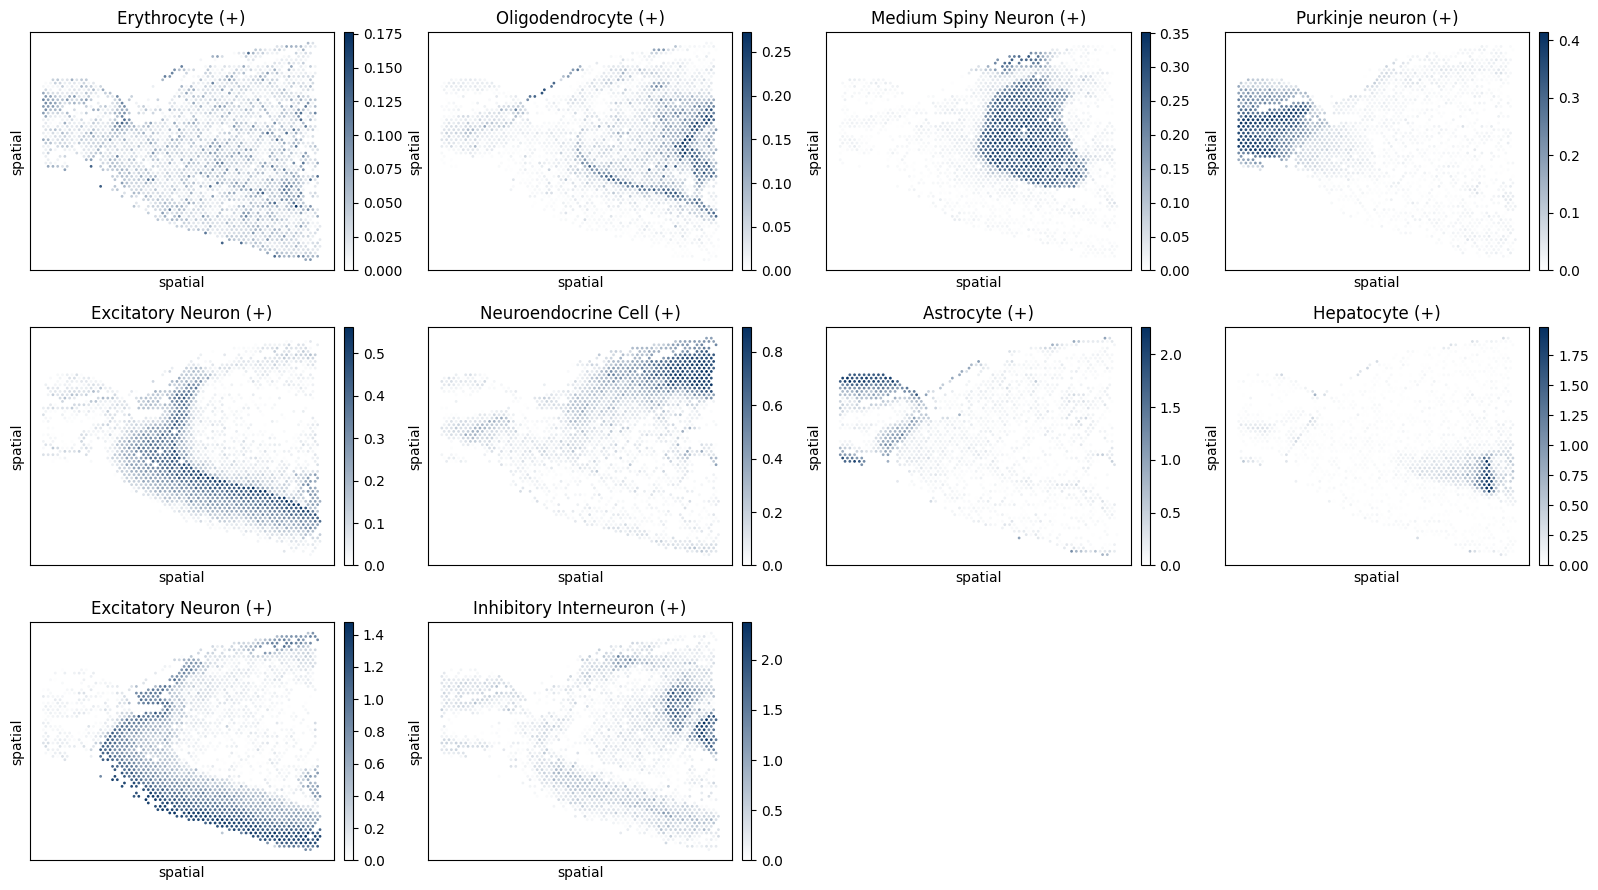

In [33]:
_ = sl.pl.factor_embedding(
    adata, 
    obsm_key="X_nmf",
    basis='spatial',
    annotation_key="factor_annotation"
)
plt.tight_layout()